In [1]:
import numpy as np
import pandas as pd
from core.helper_functions import plot_mean_std_development

/home/thorben/phd/dataspell_interpreter/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [2]:
def shuffle(v):
    ids = np.arange(len(v))
    np.random.shuffle(ids)
    return v[ids]

def final_value(values:np.ndarray):
    return values[:, -1]

def improvement(values):
    return values[:, -1] - values[:, 0]

def auc(values):
    v = np.sum(values, axis=1) / values.shape[1]
    return np.squeeze(v)

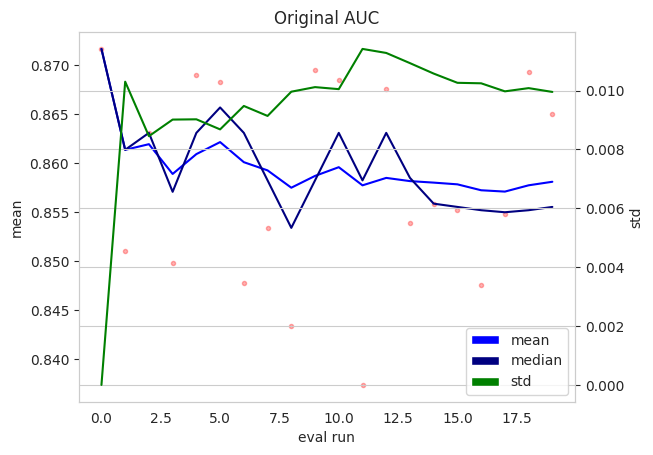

Permutations


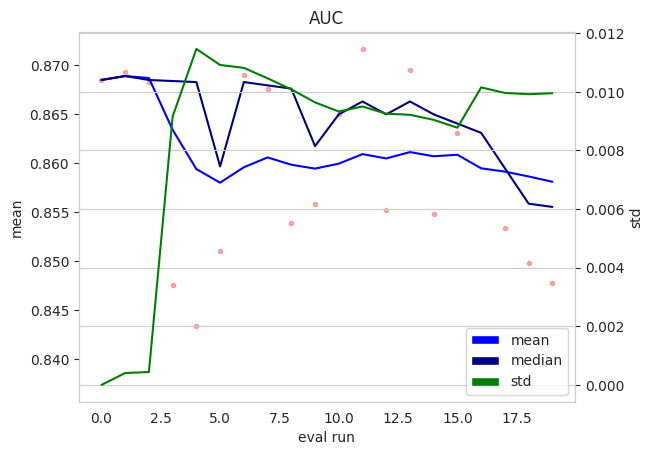

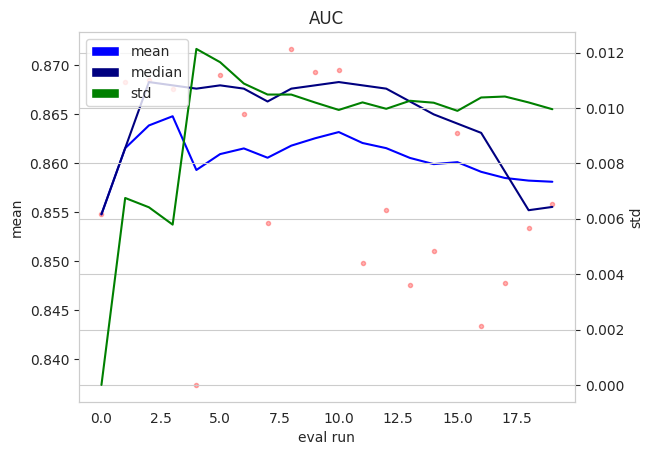

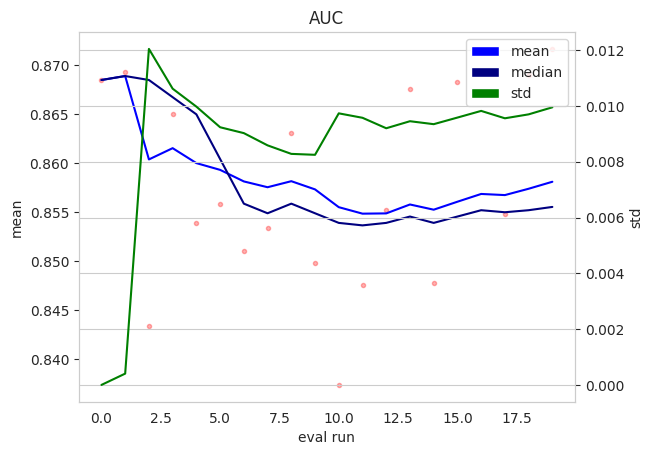

In [8]:
file = "runs/DNA/Oracle/accuracies.csv"
accuracies = pd.read_csv(file, header=0, index_col=0)
values = accuracies.values.T
plot_mean_std_development(auc(values), "Original AUC")
print("Permutations")
v = shuffle(values)
plot_mean_std_development(auc(v), "AUC")
v = shuffle(values)
plot_mean_std_development(auc(v), "AUC")
v = shuffle(values)
plot_mean_std_development(auc(v), "AUC")